## Student ID: 190428550

### Machine Learning and Neural Networks - Template (1)
### Deep Learning on a Public Dataset

### 1. Define the problem and assemble the dataset

The delay of flights will be predicted in this assignment. The data is obtained from Harvard Dataverse and converted into a CSV format for accessibility.

The data contained in this dataset contains columns which are redundant for the exploration of our topic. The columns that will be used as our input to predict flight delays are:

Categorical features:

Month - Month<br>
Day Of Week - Day of Week<br> 
UniqueCarrier - Unique Carrier<br> 
Origin - Origin airport<br> 
Dest - Destination airport<br> 
HourOfDay - Hour(24H format) based on scheduled departure time (CRSDepTime)<br> 

Numerical feature:

Distance - Distance between airports (miles) 

This problem type falls under binary classification as there are only two outputs: Delayed / Not delayed

According to the Bureau of Transportation Statistics, flights that arrive or depart 15 minutes after the scheduled time are considered delayed. Conversely, if a flight arrives or departs within 15 minutes of the scheduled time, it will be considered to be on time.

A target variable column, 'Delayed', will be created which takes integer 1 or 0. Delayed = 1 if ArrDelay exceeds 15 minutes and 0 otherwise.

Problems that may arise given the dataset used:

The dataset only contains the records from the year of 2007. The latest dataset available is from 2008, but only contains the first 4 months of 2008. Hence, the dataset for 2007 was chosen and it is the lastest and most complete.

Although a full range of data is available from 1987 to 2007, only data from the year 2007 will be used for this assigment due to computational limitations. 2007.csv contains more than 7 million rows on its own and takes more than 7 hours to train the model once. Although this is the lastest dataset available, it may not be able to predict current data accurately as the data is more than a decade old. We will be making the assumption that the future will behave like the past.

### 2. Choosing a measure of success

Accuracy metric was initially chosen to gauge our success levels. However, it was found that it does not provide an accurate representation of the model's success. Based on the dataset, an average of 78% of flights are on time and 22% are delayed. Since the data is imbalanced in this case, accuracy cannot be used as the measure of success as it may produce a biased result.

### 3. Deciding on an evaluation protocol (Testing)

The model will be evaluated using hold-out validation as we have a large number of data to utilise. The dataset will be split into ‘train’ and ‘test’ sets to evaluate how well the model works on data that has not yet been seen. The training set will be used to train the model. When employing the hold-out method, a typical split is to use 80% of the data for training and the remaining 20% for testing. A confusion matrix will be used to summarise the performance of the classifier.

### 4. Preparing your data

To prepare the data for training, vectorization will be performed on the values in the dataset. The dataset is made up of strings and integers. One-hot encoding must be used on the strings to convert them into a tensor of float32 data for TensorFlow to accept. Furthermore, the data will need to be normalised so that the network can converge. The values will be adjusted by ratio into the range 0-1. The features will also be normalised so that they have a mean of 0 and a standard deviation of 1. The dataset will be examined for invalid or missing values.

In [1]:
# pip install tensorflow
# pip install keras

In [2]:
import pandas as pd
import numpy as np
import os

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# read in data from csv, extract 100k samples
# processing data from the other columns

airplane_data = pd.read_csv("2007.csv")
airplane_data = airplane_data.sample(n=100000)

airplane_data['CRSDepTime'].isna().sum() # There are no NA's

airplane_data['CRSDepTime'] = airplane_data['CRSDepTime'].astype(str)
length_of_crsdeptime = airplane_data['CRSDepTime'].str.len()
airplane_data['HourOfDay'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [airplane_data['CRSDepTime'].str[0:2], airplane_data['CRSDepTime'].str[0:1], 0], np.nan)
airplane_data['HourOfDay'] = airplane_data['HourOfDay'].astype(int)

In [4]:
# adding a column to determine if flight was delayed based on the arrival delay time

airplane_data = airplane_data.copy()
airplane_data['Delayed'] = np.where(airplane_data['ArrDelay'] > 15, 1, 0) # Creating 'Delayed' column. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. 
airplane_data = airplane_data[['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']] # Keeping only columns that will be used as features and target variable.

In [5]:
airplane_data.head()

,Month,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,HourOfDay,Delayed
674929,2,7,WN,PHL,JAX,742,9,0
1600374,3,7,MQ,ABI,DFW,158,6,1
4229482,7,7,AA,MIA,JFK,1090,17,1
6134726,10,3,AA,STL,BOS,1046,7,0
4408829,8,1,WN,BNA,HOU,670,21,0


In [6]:
# created the features and labels

airplane_features = airplane_data.copy()
airplane_labels = airplane_features.pop('Delayed')

In [7]:
airplane_features.dtypes

Month             int64
DayOfWeek         int64
UniqueCarrier    object
Origin           object
Dest             object
Distance          int64
HourOfDay         int32
dtype: object

In [8]:
# splitting the training and test set into 80:20 ratio

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(airplane_features, airplane_labels, test_size=0.2, random_state=1)

In [9]:
# converting data types for keras

inputs = {}

for name, column in airplane_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'Month': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Month')>,
 'DayOfWeek': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'DayOfWeek')>,
 'UniqueCarrier': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'UniqueCarrier')>,
 'Origin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Origin')>,
 'Dest': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Dest')>,
 'Distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Distance')>,
 'HourOfDay': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HourOfDay')>}

In [10]:
# normalizing numerical values

numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(airplane_features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>

In [11]:
preprocessed_inputs = [all_numeric_inputs]

In [12]:
# performing one hot encoding to categorical data

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary=np.unique(airplane_features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [13]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
airplane_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [14]:
airplane_features_dict = {name: np.array(value) 
                     for name, value in airplane_features.items()}

In [15]:
# feeding all the processed data to the tensor

features_dict = {name:values[:1] for name, values in airplane_features_dict.items()}
airplane_preprocessing(features_dict)

<tf.Tensor: shape=(1, 622), dtype=float32, numpy=
array([[-1.322,  1.54 ,  0.047, -0.873,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   

In [16]:
# Create function to plot graphs

import matplotlib.pyplot as plt

def plot_loss(loss, val_loss):
    plt.clf()
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_accuracy(acc, val_acc):
    plt.clf()
    epoch = range(1, len(acc) +1)
    plt.plot(epoch, acc, 'bo', label="Training Accuracy")
    plt.plot(epoch, val_acc, 'b', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### Developing the baseline model

In [17]:
# creating AUC metric

tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)

In [18]:
from tensorflow import keras
from keras import optimizers

def airplane_baseline_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(optimizer=tf.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
    return model

airplane_baseline_model = airplane_baseline_model(airplane_preprocessing, inputs)
history_base = airplane_baseline_model.fit(x=airplane_features_dict, 
                                           y=airplane_labels,
                                           epochs=10,
                                           batch_size = 512,
                                           validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 2s 7ms/step - loss: 0.5618 - accuracy: 0.7522 - auc_1: 0.5560 - val_loss: 0.5221 - val_accuracy: 0.7660 - val_auc_1: 0.6390
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5151 - accuracy: 0.7693 - auc_1: 0.6488 - val_loss: 0.5191 - val_accuracy: 0.7660 - val_auc_1: 0.6471
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5114 - accuracy: 0.7693 - auc_1: 0.6589 - val_loss: 0.5182 - val_accuracy: 0.7660 - val_auc_1: 0.6501
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5089 - accuracy: 0.7693 - auc_1: 0.6660 - val_loss: 0.5176 - val_accuracy: 0.7657 - val_auc_1: 0.6519
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5065 - accuracy: 0.7695 - auc_1: 0.6716 - val_loss: 0.5173 - val_accuracy: 0.7653 - val_auc_1: 0.6532
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5044 - accuracy: 0.7701 - auc_1: 0

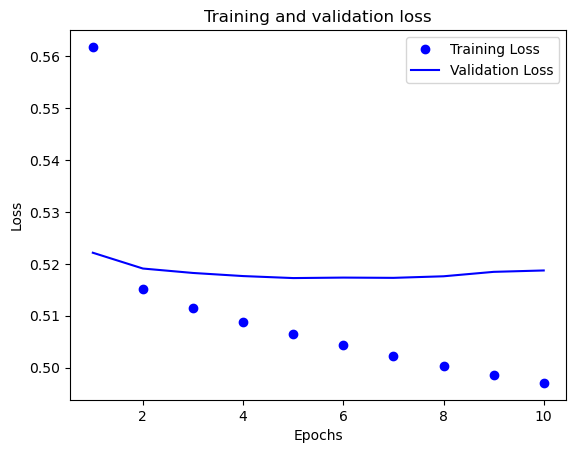

In [19]:
plot_loss(history_base.history['loss'], history_base.history['val_loss'])

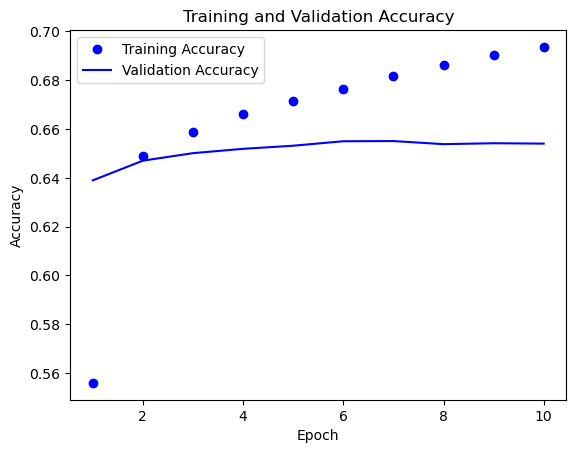

In [20]:
plot_accuracy(history_base.history['auc_1'], history_base.history['val_auc_1'])

In [21]:
loss, auc, accuracy = airplane_baseline_model.evaluate(x=airplane_features_dict, y=airplane_labels, verbose = 2)

3125/3125 - 6s - loss: 0.4982 - accuracy: 0.7711 - auc_1: 0.6928 - 6s/epoch - 2ms/step


### Loss: 0.50,  AUC: 0.69,  Accuracy: 77.11%

The AUC obtained a result of 0.68 while the loss function obtained a results of 0.50. The result at this point is acceptable enough to determine that the model has statistical power and can be improved further. The shape of the graph determines that the model is overfitting. In the following weeks, an underfitting model will be created so we can have a rough idea of where a well performing model stands (between the current overfitting and underfitting model).